# Reinforcement Learning - Toy examples with Gym

## FrozenLake

In this Notebook, we will implement $SARSA$ and $Q-Learning$ methods to solve the FrozenLake8x8 environment (https://gym.openai.com/envs/FrozenLake-v0/), using and comparing different policies for exploration. Note that it is a stochastic envivonment since, as mentioned in the documentation, "the ice is slippery, so you won't always move in the direction you intend".

Both algorithms update a tabular estimate of the $Q-function$ using a following update rule:
* $SARSA$ algorithm is an on-policy method using:
$$Q_{t+1}(s_t,a_t) \leftarrow Q_t(s_t,a_t) + \alpha (r_t + \gamma Q_t(s_{t+1}, a_{t+1}) - Q_t(s_t,a_t))$$

* $Q-Learning$ algorithm is an off-policy method using:
$$Q_{t+1}(s_t,a_t) \leftarrow Q_t(s_t,a_t) + \alpha (r_t + \gamma \max_b Q_t(s_{t+1}, b) - Q_t(s_t,a_t))$$

For exploration, we will compare performances between:
* $\epsilon$-greedy policy with a fixed $\epsilon$.
* $\epsilon$-greedy policy with a decaying $\epsilon$.
* softmax exploration assigning a probability for an action to be
performed according to the following rule:
$$P(a_i \vert s) = \frac{e^{\frac{1}{\tau}Q(s,a_j)}}{\sum_j e^{\frac{1}{\tau}Q(s,a_j)}}$$

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [4]:
env = gym.make("FrozenLake8x8-v0")

c:\environments\drl_env\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [5]:
def chooseAction(q_table, state, epsilon = 0, softmax = True, tau = 0.01):
    """Choose an action.
  
  Args:
    q_table: Q-table.
    state: state
    epsilon: epsilon
    softmax: boolean set to $True$ if softmax exploration is used
    tau: parameter of the softmax exploration.
  Returns:
    Action 
  """
    if softmax:
        m = max(q_table[state])
        aux = np.exp((q_table[state] - m)/tau)
        d = np.sum(aux)
        return np.random.choice (np.arange(env.action_space.n), p=aux / d)
    if np.random.random () > epsilon:
        return np.argmax(q_table[state])
    return env.action_space.sample()

In [6]:
def routine(algo, nEpisode = 2000, gamma = 0.99, alpha = 0.4, epsilon0 = 0.9, epsilonMin = 0.05, decreaseRate = 0.999, softmax = False, tau = 0.01, window = 100):
    """Body function used to implement both $SARSA$ and $Q$-Learning, since only the estimation of the error changes between the two methods.
  
  Args:
    algo: either "SARSA" or "QLearning"
* nEpisode: number of episodes we simulate to update our Q-function
* gamma: discount factor
* alpha: learning rate
* epsilon_0: initial value of epsilon
* epsilonMin: minimal value of $\epsilon$ if a decaying $\epsilon$ is used
* decreaseRate: geometric parameter of the decaying of epsilon (set to 1 if no decaying)
* softmax: boolean set to True if softmax exploration is used
* tau: parameter of the softmax exploration
* window: number of episodes we consider to compute the success rate (or accuracy) of the Q-function ; ratio of successes on the last $window$ episodes
  Returns:
    q_table: the Q-table
    histAcc: array where accuracies are stored 
  """
    accuracy = 0
    epsilon = epsilon0
    q_table = np.ones((env.observation_space.n, env.action_space.n))
    result = np.zeros (window)
    histAcc = [0]
    episode = 0
    
    for ep in range(nEpisode):
        epsilon = max(epsilonMin, decreaseRate * epsilon)
        observation0 = env.reset()
        action0 = chooseAction(q_table, observation0, epsilon, softmax, tau)
        done  = False
        for H in range(200):
            observation1, reward, done, info = env.step(action0)
            action1 = chooseAction(q_table, observation1, epsilon, softmax, tau)
            err = reward - q_table[observation0, action0]
            
            if not done:
                if algo == "SARSA":
                    err += gamma * q_table[observation1, action1]
                if algo == "QLearning":
                    err += gamma * q_table[observation1, np.argmax(q_table[observation1])]
            
            q_table[observation0, action0] += alpha * err
            
            if done:
                break
            
            observation0, action0 = observation1, action1

        success = 1 if (reward == 1) else 0
        accuracy += (success - result[episode]) / window
        result[episode] = success
        episode = (episode + 1) % window
        if episode == 0 or episode == window//2: # accuracy ratio is stored once in @window/2 episodes
            histAcc.append(accuracy)

    return q_table, histAcc

In [7]:
def routineTh(algo, threshold = 0.8, gamma = 0.99, alpha = 0.4, epsilon0 = 0.9, epsilonMin = 0.05, decreaseRate = 0.999, softmax = False, tau = 0.01, window = 100):
    accuracy = 0
    epsilon = epsilon0
    q_table = np.ones((env.observation_space.n, env.action_space.n))
    result = np.zeros (window)
    histAcc = [0]
    episode = 0
    
    while accuracy < threshold:
        epsilon = max(epsilonMin, decreaseRate * epsilon)
        observation0 = env.reset()
        action0 = chooseAction(q_table, observation0, epsilon, softmax, tau)
        done  = False
        for H in range(200):
            observation1, reward, done, info = env.step(action0)
            action1 = chooseAction(q_table, observation1, epsilon, softmax, tau)
            err = reward - q_table[observation0, action0]
            
            if not done:
                if algo == "SARSA":
                    err += gamma * q_table[observation1, action1]
                if algo == "QLearning":
                    err += gamma * q_table[observation1, np.argmax(q_table[observation1])]
            
            q_table[observation0, action0] += alpha * err
            
            if done:
                break
            
            observation0, action0 = observation1, action1

        accuracy += (reward - result[episode % window]) / window
        result[episode % window] = reward
        episode = episode + 1 
        histAcc.append(accuracy)

    return q_table, histAcc, episode

### SARSA

In [ ]:
def SARSA(nEpisode = 2000, gamma = 0.999, alpha = 0.4, epsilon0 = 0.9, epsilonMin = 0.05, decreaseRate = False, softmax = True, tau = 0.01, window = 100):
    return routine("SARSA", nEpisode, gamma, alpha, epsilon0, epsilonMin, decreaseRate, softmax, tau, window)


w = 100
nEpisode = 150000
q_table, histAcc = SARSA(nEpisode, softmax = True, window=w, tau = 0.001)
plt.plot(w // 2 * np.arange(len(histAcc)), histAcc)

plt.xlabel("Number of episodes")
plt.ylabel("Accuracy on the {} last episodes".format(w))
plt.title("SARSA training on {} episodes".format(nEpisode))

In [35]:
def SARSATh(threshold = 0.8, gamma = 0.999, alpha = 0.4, epsilon0 = 0.9, epsilonMin = 0.05, decreaseRate = False, softmax = True, tau = 0.01, window = 100):
    return routineTh("SARSA", threshold, gamma, alpha, epsilon0, epsilonMin, decreaseRate, softmax, tau, window)


w = 100
threshold = 0.8
q_table, histAcc, episode = SARSATh(threshold, softmax = True, window=w, tau = 0.001)
plt.plot(np.arange(len(histAcc)), histAcc)

plt.xlabel("Number of episodes")
plt.ylabel("Accuracy on the {} last episodes".format(w))
plt.title("Threshold".format(threshold))

KeyboardInterrupt: 

### $Q$-Learning

Text(0.5, 1.0, 'Q-Learning training on 2000 episodes')

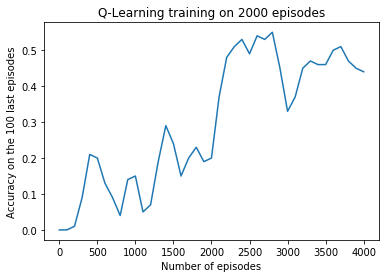

In [17]:
def QLearning(nEpisode = 2000, gamma = 0.999, alpha = 0.4, epsilon0 = 0.9, epsilonMin = 0.05, decreaseRate = True, softmax = False, tau = 0.003, window = 100):
    return routine("QLearning", nEpisode, gamma, alpha, epsilon0, epsilonMin, decreaseRate, softmax, tau, window)

w = 100
nEpisode = 2000
q_table, histAcc = QLearning (nEpisode, softmax = True, window=w)
plt.plot(100 * np.arange(len(histAcc)), histAcc)

plt.xlabel("Number of episodes")
plt.ylabel("Accuracy on the {} last episodes".format(w))
plt.title("Q-Learning training on {} episodes".format(nEpisode))

7174


Text(0.5, 1.0, 'Threshold')

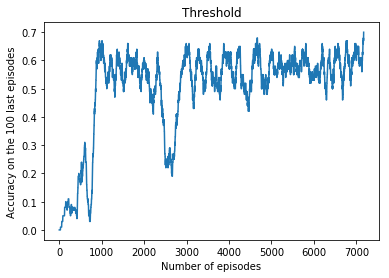

In [23]:
def QLearningTh(threshold = 0.8, gamma = 0.999, alpha = 0.4, epsilon0 = 0.9, epsilonMin = 0.05, decreaseRate = False, softmax = True, tau = 0.01, window = 100):
    return routineTh("QLearning", threshold, gamma, alpha, epsilon0, epsilonMin, decreaseRate, softmax, tau, window)


w = 100
threshold = 0.7
q_table, histAcc, episode = QLearningTh(threshold, softmax = True, window=w, tau = 0.001)
print(episode)
plt.plot(np.arange(len(histAcc)), histAcc)

plt.xlabel("Number of episodes")
plt.ylabel("Accuracy on the {} last episodes".format(w))
plt.title("Threshold".format(threshold))

In [26]:
def testPolicy (q_table, nEpisode = 2000):
    success = 0
    for _ in range(nEpisode):
        t = 0
        observation = env.reset()
        done  = False
        actionTable = np.argmax(q_table, axis = 1)
        while not done and t < 200:
            action = actionTable[observation]
            observation, reward, done, info = env.step(action)
            t += 1

        if reward == 1:
            success += 1
    return success / nEpisode

In [31]:
testPolicy(q_table, nEpisode = 2000)

0.5975

## Compare methods

In [24]:
recap = pd.DataFrame (columns = ["Accuracy - SARSA", "Accuracy - QLearning"])

N = 5000

### $\epsilon$-greedy with fixed $\epsilon$

In [25]:
n = 5
Eps = 0.1 * np.arange(1, 10)

for eps in Eps:
    sarsa = 0
    ql = 0
    for _ in range(n):
        q_table, histAcc = QLearning (N, epsilon0 = eps, decreaseRate=1)
        ql += testPolicy(q_table)
        q_table, histAcc = SARSA (N, epsilon0 = eps, decreaseRate=1)
        sarsa += testPolicy(q_table)
    sarsa /= n
    ql /= n
    recap.loc["Fixed $\epsilon$ : $\epsilon$ = {}".format(round(eps,2))] = [sarsa, ql]

### $\epsilon$-greedy with decaying $\epsilon$

In [26]:
n = 5
DR = [0.9, 0.99, 0.999]
eps = 0.9

for dr in DR:
    sarsa = 0
    ql = 0
    for _ in range(n):
        q_table, histAcc = QLearning (N, epsilon0 = eps, decreaseRate=dr)
        ql += testPolicy(q_table)
        q_table, histAcc = SARSA (N, epsilon0 = eps, decreaseRate=dr)
        sarsa += testPolicy(q_table)
    sarsa /= n
    ql /= n
    recap.loc["Decaying-$\epsilon$ : decaying rate = {}".format(dr)] = [sarsa, ql]


### Softmax

In [22]:
n = 5

for t in [1, 0.1, 0.01, 0.001]:
    sarsa = 0
    ql = 0
    for _ in range(n):
        q_table, histAcc = QLearning(N, softmax = True, tau = t)
        ql += testPolicy(q_table)
        q_table, histAcc = SARSA(N, softmax = True, tau = t)
        sarsa += testPolicy(q_table)
    sarsa /= n
    ql /= n
    recap.loc["Softmax : $\tau$ = {}".format(t)] = [sarsa, ql]

,Accuracy - SARSA,Accuracy - QLearning
Fixed $\epsilon$ : $\epsilon$ = 0.1,0.6433,0.5647
Fixed $\epsilon$ : $\epsilon$ = 0.2,0.7481,0.6517
Fixed $\epsilon$ : $\epsilon$ = 0.3,0.6477,0.3307
Fixed $\epsilon$ : $\epsilon$ = 0.4,0.6386,0.5152
Fixed $\epsilon$ : $\epsilon$ = 0.5,0.6995,0.3537
Fixed $\epsilon$ : $\epsilon$ = 0.6,0.7355,0.5556
Fixed $\epsilon$ : $\epsilon$ = 0.7,0.7075,0.4808
Fixed $\epsilon$ : $\epsilon$ = 0.8,0.6889,0.5127
Fixed $\epsilon$ : $\epsilon$ = 0.9,0.7062,0.4885
Decaying-$\epsilon$ : decaying rate = 0.9,0.7413,0.4818


In [ ]:
recap

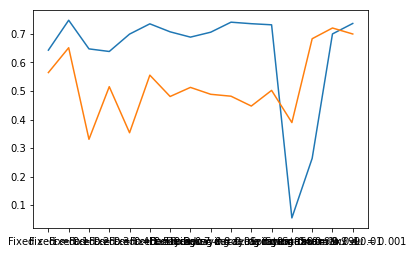

In [23]:
plt.plot(recap)